# GPR for Mtm swap portfolio fitting :

In [1]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Projet Quadrature bayésienne'

In [2]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
img_path = project_path +'\Results\Images'

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(lib_path)        

from main import *
from FinancialData import *
from Chebychev import *

## Data Extraction & tools :

In [4]:
def GPR_Mtm_ploter(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm.reshape(diff.nbr_scenarios), label ='GPR')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('GPR', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='True')

        plt.scatter(train_points,mtm_points,c='r')

        plt.plot(np.sort(diff.X(t)) , Mtm.reshape(diff.nbr_scenarios) , label='GPR')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm_ploter(t, diff, irs, ZC, nodes_nbr,diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm, label ='Chebyshev')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('Chebyshev', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
        
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

        plt.scatter(train_points,mtm_points,c='r')
        plt.plot(np.sort(diff.X(t)) , Mtm , label='Chebyshev')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm(t, diff, irs, ZC, nodes_nbr) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    return Mtm

def GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())
    
    if (mtm_points == np.zeros(nodes_nbr) ).all():
        return 0

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    
    return Mtm.reshape(diff.nbr_scenarios)





In [5]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

# nbr_swap = 50

# irs = IrsPortfolio(nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
#                  maturity=list(np.arange(1, 7 + 0.5, 0.5)),
#                  fix_rate=[0.02, 0.05], exercice=['payer','reciver'], SEED=1999)


with open(port_path+'\port400irs1fx', 'rb') as f1:
    irs = pickle.load(f1)
    
# Set Maturity     
T = irs.last_maturity
irs.print_as_dict()


{'first_reset_date': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [59]:
#LGM params
sig = 0.005 
lam = 0.01

#Diffusion params
T = irs.last_maturity
n =  int(T*360) +1 
NBR_SCENARIOS = 10000

tt= time()
diff =Diffusion(0, T, n, sig, lam, NBR_SCENARIOS, pb_measure='Terminal at t')
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )

Diffusion Time 0:00:01


## Fitting Mtm distrubition by GPR

Our test will be conducted at fixed time $t$ and using only 10000 scenarios for simplicity

In [6]:
#LGM params
sig = 0.005 
lam = 0.01

#Diffusion params
T = irs.last_maturity
n =  int(T*360) +1 
NBR_SCENARIOS = 10000

tt= time()
diff =Diffusion(0, T, n, sig, lam, NBR_SCENARIOS, pb_measure='Terminal at t')
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )

Diffusion Time 0:00:01


We plot different style of histogram to see how GPR with only 5 pts can fit perfectly the Mark to Marekt distrubition 

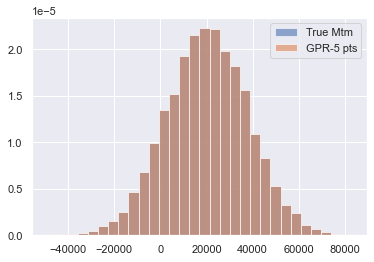

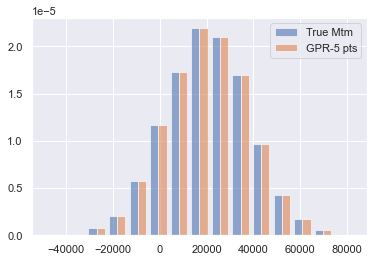

In [60]:
t = 5

x =irs.Mtm(t,diff,ZC)
plt.hist(x,bins=30, density=True, alpha=0.6, label='True Mtm')
for nodes_nbr in [5] :

    y = GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False)
    plt.hist(y,density=True ,bins=30, alpha=0.6,  label='GPR'+'-'+str(nodes_nbr)+' pts')
    
plt.legend(loc='upper right')
plt.show()


data=[x]
labels=['True Mtm']
for nodes_nbr in [5] :  
    data.append(GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False))
    labels.append('GPR'+'-'+str(nodes_nbr)+' pts')
    
plt.hist(data,density=True ,bins=15, alpha=0.6, label=labels)
plt.legend(loc='upper right')
plt.show()


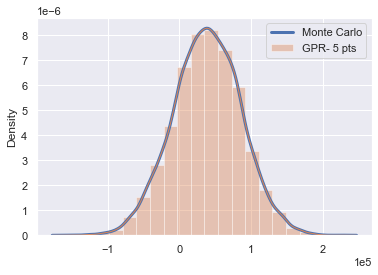

In [61]:
t= 3

x =irs.Mtm(t,diff,ZC)

sns.distplot(x, hist = False, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='Monte Carlo')


for nodes_nbr in [5] :
    
    y = GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False)
    ax = sns.distplot(y, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 1}, label = 'GPR'+'- '+str(nodes_nbr)+' pts')
    #sns.kdeplot(y, label = 'GPR'+'- '+str(nodes_nbr)+' pts')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.plot()
    
    
plt.legend()
plt.show()

Normality test  : 

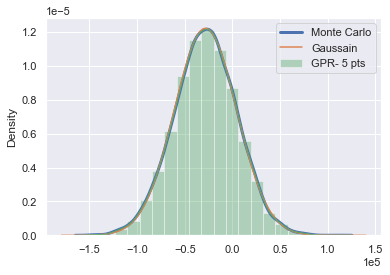

In [62]:
t= 0.25
x =irs.Mtm(t,diff,ZC)

sns.distplot(x, hist = False, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='Monte Carlo')
# Plot the PDF.
xmin, xmax = plt.xlim()
ax = np.linspace(xmin, xmax, 100)
p = norm.pdf(ax, np.mean(x) ,  np.std(x))
plt.plot(ax,p,label='Gaussain')

for nodes_nbr in [5] :
    
    y = GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False)
    ax = sns.distplot(y, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 1}, label = 'GPR'+'- '+str(nodes_nbr)+' pts')
    #sns.kdeplot(y, label = 'GPR'+'- '+str(nodes_nbr)+' pts')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.plot()
    
    
plt.legend()
plt.show()

Empirically,  we can assert that the distribution of the Mtm is approximately Gaussian ! toi be investigated ...

## PFE profil 

In [94]:
def PFE(t,alpha,irs,diff,ZC, GPR=False):
    
    if GPR :
        Vt = GPR_Mtm(t, diff, irs, ZC, 5, diag=False) 
    else :
        Vt =irs.Mtm(t,diff,ZC)
    
    return np.percentile(np.maximum(Vt,0),alpha)

    
    

In [97]:
alpha = 95
T = irs.last_maturity
time_grid = np.linspace(0,T,50)
mc_start = time()
PFE_mc = np.array([PFE(t,alpha,irs,diff,ZC) for t in time_grid])
mc_time = time()-mc_start 


In [107]:

time_grid = np.linspace(0,T,50)
gp_start = time()
PFE_gp = np.array([PFE(t,alpha,irs,diff,ZC,GPR=True) if t>0 else 0 for t in time_grid])
gp_time = time()-gp_start 


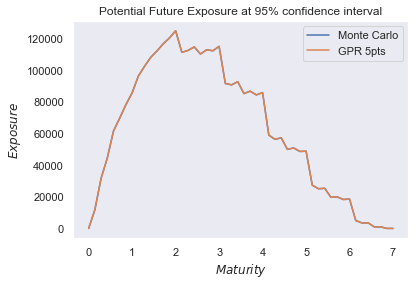

PFE Monte Carlo time is : 86
PFE GPR time is : 7
Speedup factor : 13


In [127]:
plt.figure()
plt.plot(time_grid, PFE_mc, label="Monte Carlo")
plt.plot(time_grid, PFE_gp,  label="GPR 5pts")

plt.legend()
plt.xlabel(r"$Maturity$")
plt.ylabel(r"$Exposure$")
plt.grid(False)
plt.title( 'Potential Future Exposure at ' +str(alpha)+ '% confidence interval' )

plt.show()

print('PFE Monte Carlo time is :' , round(mc_time) )

print('PFE GPR time is :' , round(gp_time) )
print('Speedup factor :' , round(mc_time/gp_time))

In [129]:
def MRE(pred,true):
    ecart = np.abs(pred-true)
    true_abs = np.abs(true)
    return np.mean(ecart[true_abs != 0]/true_abs[true_abs != 0])

round(100*MRE(PFE_gp,PFE_mc),2)

0.06

## GPR

In [15]:
# We tested on different values of t
t = 2 #6.14

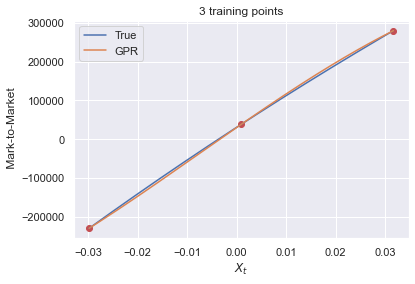

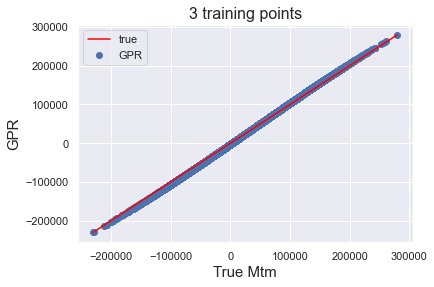

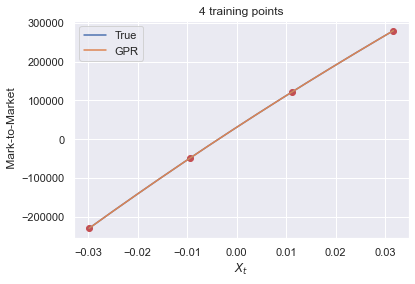

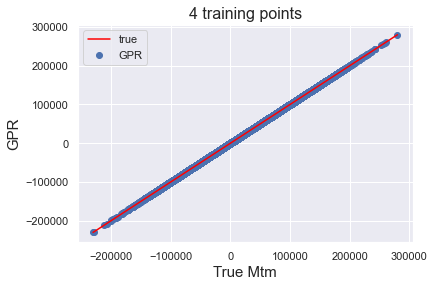

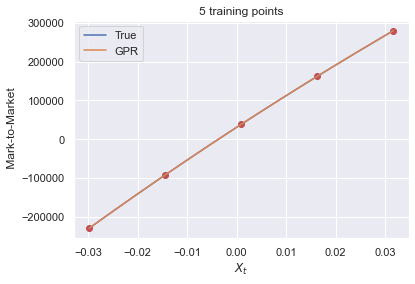

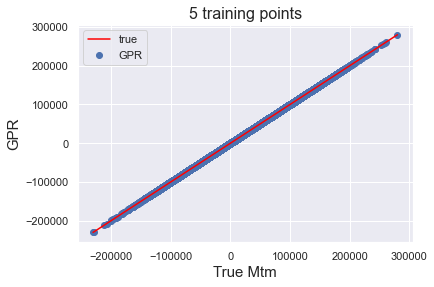

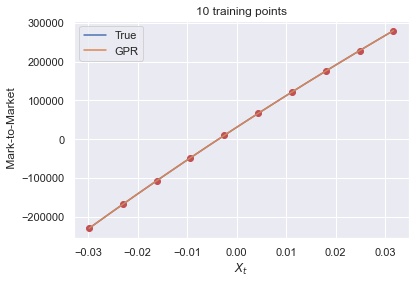

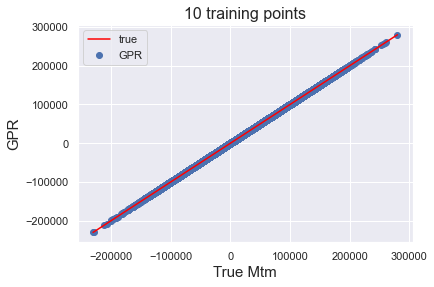

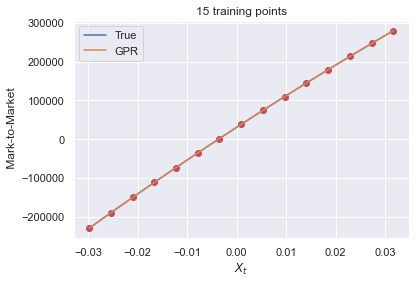

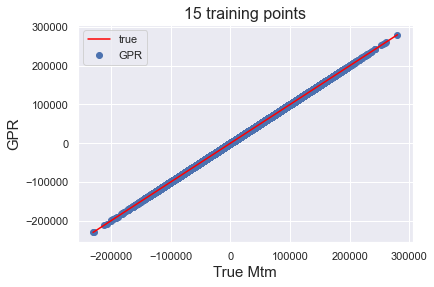

In [16]:
nodes_numbers = [3,4,5,10,15]

for n in nodes_numbers :
    GPR_Mtm_ploter(t, diff, irs, ZC, n)
    GPR_Mtm_ploter(t, diff, irs, ZC, n,True)
    

    Graphically, it seem that with only a few points (4 or 5) can fit the Mtm wich is quasi-linear 

## Numerical Test :

In [112]:
def MAE(pred, true):
    return np.mean(np.abs(pred-true))
def MRE(pred, true):
    return np.mean(np.abs(pred-true)/np.abs(true))

$MAE := \frac{1}{n} \sum_{i=1}^{n} |Pred_{i} \:  - \; True_i|  \\
MRE := \frac{1}{n} \sum_{i=1}^{n} \frac{|Pred_{i} \:  - \; True_i|}{|True_{i}|}$

In [19]:
nodes_numbers = [3,4,5,10,15]

true_mtm = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
result = pd.DataFrame(columns=['Training','MAE', 'MRE %'])
for n in nodes_numbers :
    pred = GPR_Mtm(t, diff, irs, ZC, n)
    result.loc[len(result)] = [int(n), MAE(pred,true_mtm) , 100*MRE(pred,true_mtm)]
print('gpr Result')
result.round(2)

gpr Result


,Training,MAE,MRE %
0,3.0,2752.28,31.97
1,4.0,6.68,0.10
2,5.0,0.34,0.01
3,10.0,0.06,0.00
4,15.0,0.13,0.00


In [20]:
nodes_numbers = [3,4,5,10,15]

true_mtm = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
result = pd.DataFrame(columns=['Training','MAE', 'MRE %'])
for n in nodes_numbers :
    pred = Chebyshev_Mtm(t, diff, irs, ZC, n)
    result.loc[len(result)] = [int(n), MAE(pred,true_mtm) , 100*MRE(pred,true_mtm)]
print('Chebyshev Result')
result.round(2)

Chebyshev Result


,Training,MAE,MRE %
0,3.0,61.88,0.74
1,4.0,364.29,5.48
2,5.0,12.95,0.19
3,10.0,20.50,0.09
4,15.0,0.48,0.01
